# Demo Testing

## Tasks:
* Movement classification:
    * Pitch Type
    * Pitching Position
    * Play Outcome
* Detect events:
    * Pitcher:
        * first movement
        * ball release
    * Batter:
        * Foot highest, foot back to ground
        * First step (when starting to run)
* Ball detection

In [1]:
import sys
import os
# sys.path.append("..")
MODEL_PATH = os.path.join("saved_models")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sp
import scipy.stats
import matplotlib.pylab as plt
import json
from os import listdir
import cv2
import time
import ast
import json
from run_events import Runner
from test_script import test

from utils import Tools

/Users/ninawiedemann/anaconda/envs/baseball_analysis3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# THIS IS REQUIRED BECAUSE OF THE "3" in the module name
import importlib
mdl = importlib.import_module('3_Event_detection.detect_event')
# is there an __all__?  if so respect it
if "__all__" in mdl.__dict__:
    names = mdl.__dict__["__all__"]
else:
    # otherwise we import all names that don't begin with _
    names = [x for x in mdl.__dict__ if not x.startswith("_")]
globals().update({k: getattr(mdl, k) for k in names})

In [4]:
from fmo_detection import *
joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
        "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck ",
        "right_eye", "right_ear","left_eye", "left_ear"]

## Get data

In [5]:
example = os.path.join("demo_data","example_1") # f4ea3410-f559-464f-acb0-74133d7742e3
pitcher = from_json(example+"_pitcher.json")
batter = from_json(example+"_batter.json")
with open(example+"_video_batter.json", "r") as infile:
    videos_b = json.load(infile)
with open(example+"_video_pitcher.json", "r") as infile:
    videos_p = json.load(infile)
with open(example+"_labels.json", "r") as infile:
    labels = json.load(infile)
    
print("loaded successfully:")
print("Pitcher joints:", pitcher.shape)
print("Batter joints:", batter.shape)
print("metadata", labels)

loaded successfully:
Pitcher joints: (166, 12, 2)
Batter joints: (166, 12, 2)
metadata {'Pitch Type': 'Fastball (2-seam)', 'Pitching Position (P)': 'Stretch', 'Play Outcome': 'run'}


## Visualize pitcher and batter joints

-------------------- batter ------------------------


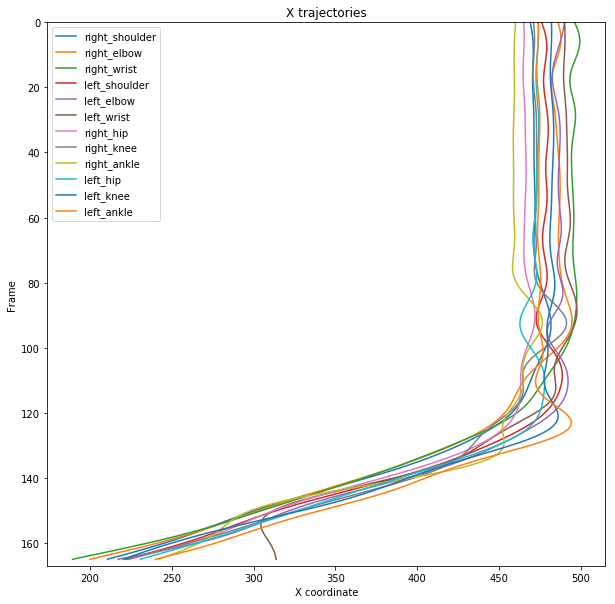

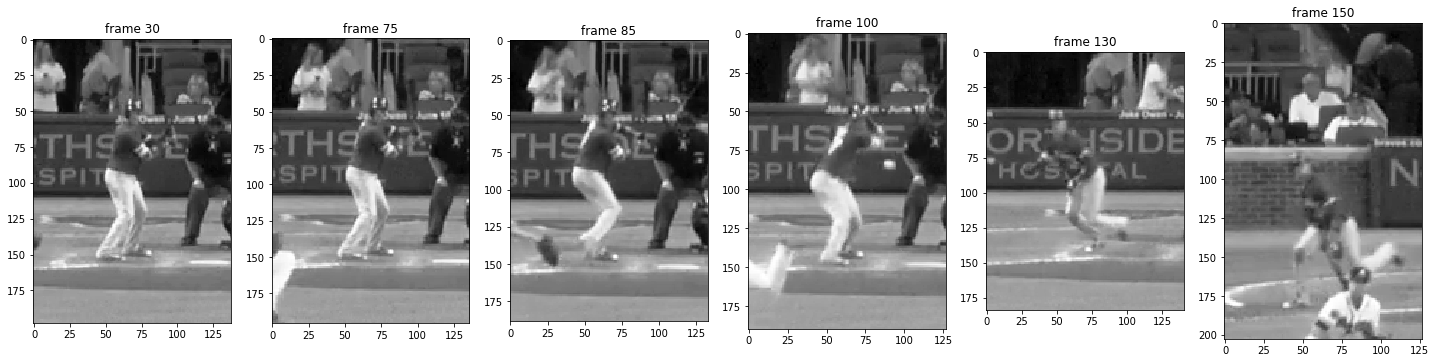

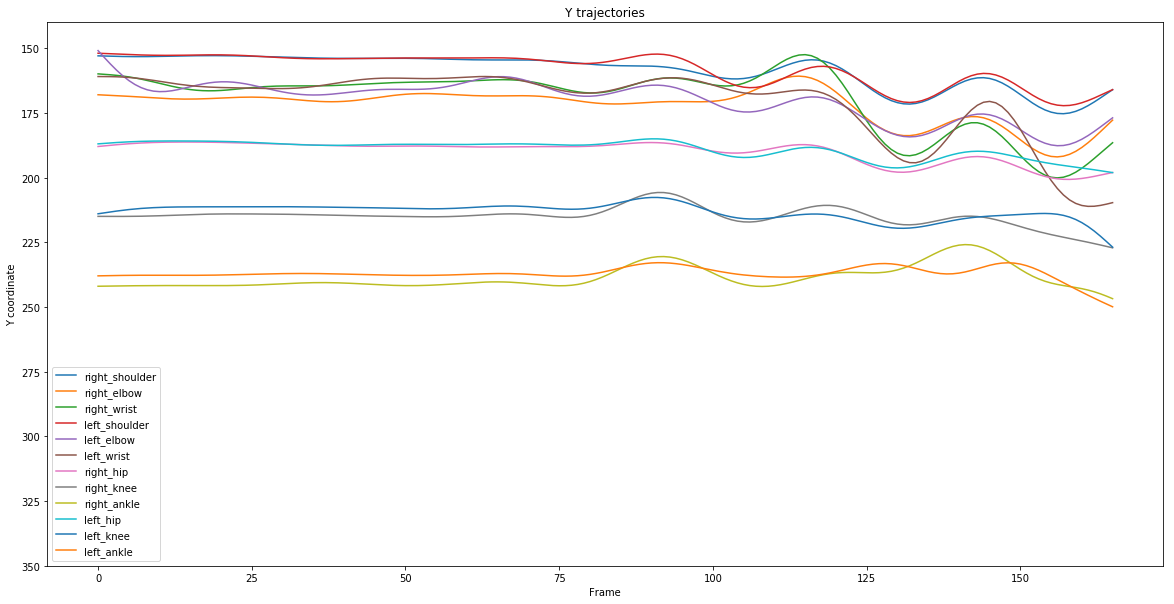

-------------------- pitcher ------------------------


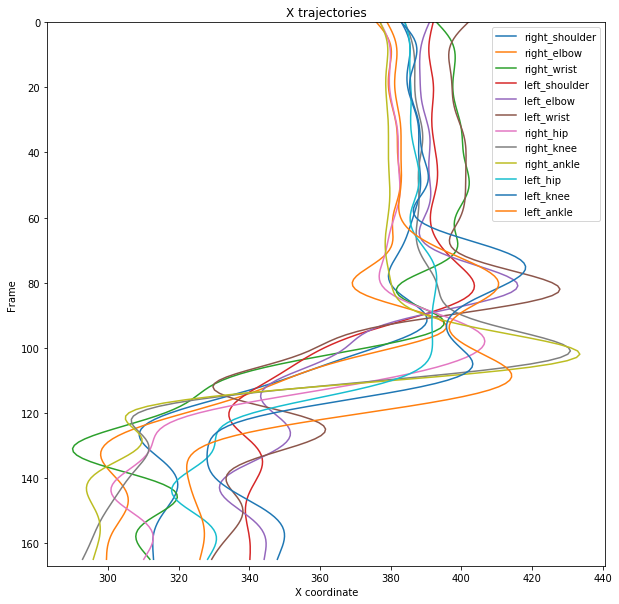

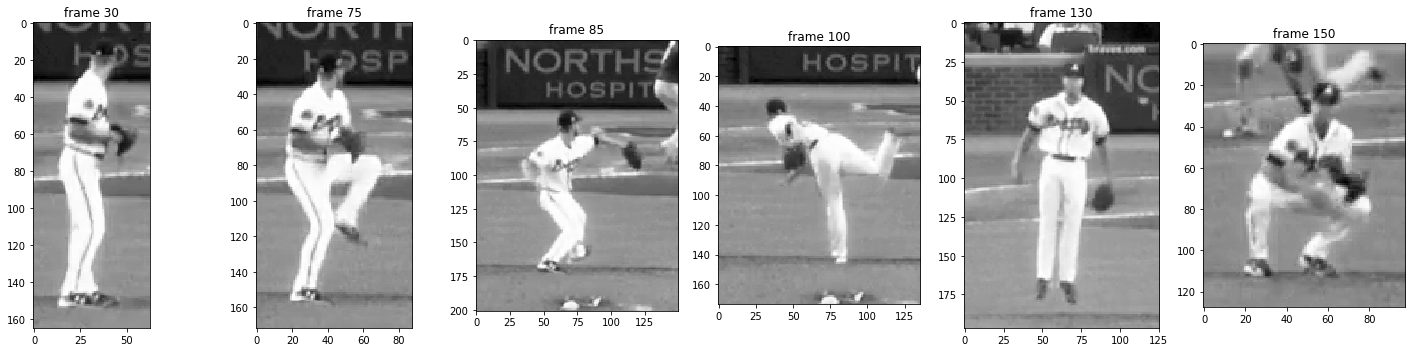

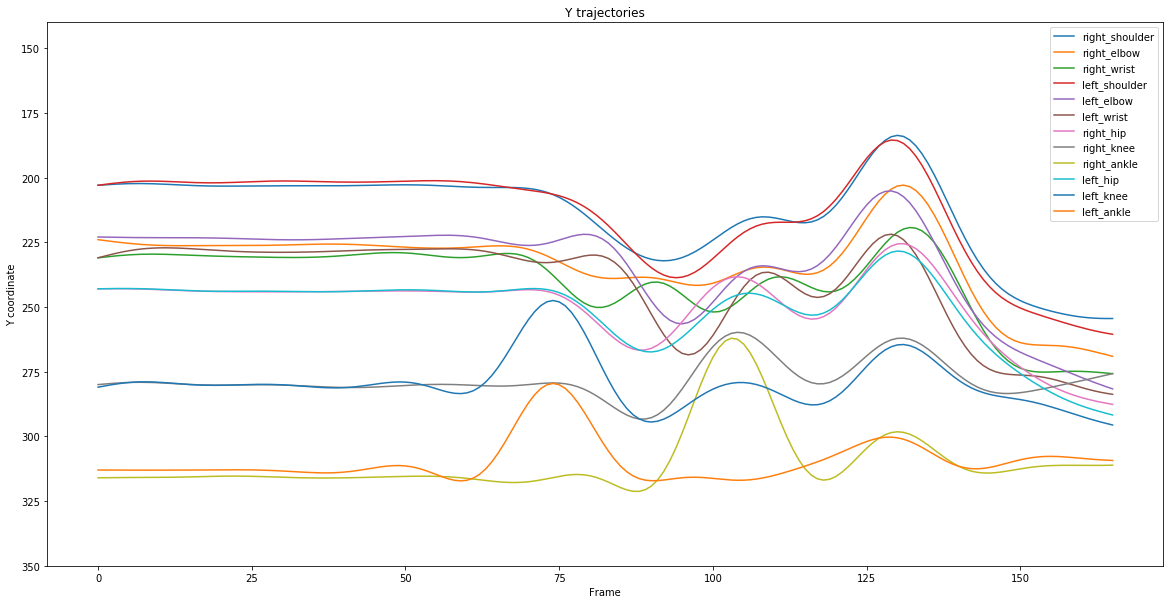

In [6]:
for video, person in zip(["videos_b", "videos_p"], ["batter", "pitcher"]):
    print("--------------------", person, "------------------------")
    plt.figure(figsize = (10,10))
    for j in joints_list[:12]:
        plt.plot(eval(person)[:,joints_list.index(j), 0], np.arange(0,len(eval(person)),1), label = j)
    plt.title("X trajectories")
    plt.ylim(167,0)
    plt.ylabel("Frame")
    plt.xlabel("X coordinate")
    plt.legend()
    plt.show()

    # Plot video frames to visualize maxima in X coordinates
    show_frames = [30, 75, 85, 100, 130, 150]
    fig = plt.figure(figsize=(20, 5))
    for ind, i in enumerate(show_frames):
        ax = fig.add_subplot(1,len(show_frames),ind+1)
        plt.imshow(eval(video)[i])
        plt.title("frame "+str(i))
        plt.gray()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (20,10))
    for j in joints_list[:12]: #[one_joint]: 
        plt.plot(eval(person)[:,joints_list.index(j), 1], label = j)
    plt.legend()
    plt.ylim(350, 140)
    plt.ylabel("Y coordinate")
    plt.xlabel("Frame")
    plt.title("Y trajectories")
    plt.show()

## Movement classification:

In [7]:
# Pitch type
normalized_trajectories_pitcher = Tools.normalize(np.array([pitcher[:160]]))
normalized_trajectories_batter = Tools.normalize(np.array([batter[:160]]))

lab, out = test(normalized_trajectories_pitcher, os.path.join(MODEL_PATH, "pitch_type"))
print("Predicted Pitch Type: ", lab, " -----  Ground truth pitch type: ", labels["Pitch Type"], "\n")

lab, out = test(normalized_trajectories_pitcher, os.path.join(MODEL_PATH, "pitching_position"))
print("Predicted pitching position: ", lab, " -----  Ground truth pitching position: ", labels["Pitching Position (P)"], "\n")

lab, out = test(normalized_trajectories_batter, os.path.join(MODEL_PATH, "play_outcome"))
print("Predicted play outcome: ", lab, " -----  Ground truth play outcome: ", labels["Play Outcome"], "\n")

INFO:tensorflow:Restoring parameters from saved_models/pitch_type
time for nr labels 0.03021693229675293
Predicted Pitch Type:  ['Fastball (2-seam)']  -----  Ground truth pitch type:  Fastball (2-seam) 

INFO:tensorflow:Restoring parameters from saved_models/pitching_position
time for nr labels 0.03338027000427246
Predicted pitching position:  ['Stretch']  -----  Ground truth pitching position:  Stretch 

INFO:tensorflow:Restoring parameters from saved_models/play_outcome
time for nr labels 0.02208876609802246
Predicted play outcome:  ['run']  -----  Ground truth play outcome:  run 



## Release frame: 

First neural network has sequence of 100 frames joint trajectory as input and 
detectes from joints which one is most likeley to be the release frame

Second neural network outputs probability for a single IMAGE to be a release position, and outputs the one with highest probability as the release frame

Higher shoulders approach: 92


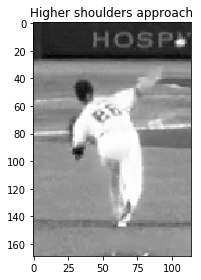

session started
INFO:tensorflow:Restoring parameters from saved_models/release_model
session restored
end of video capture
---- Release from pitcher's stance (frame by frame in 2D CNN):  92 --------


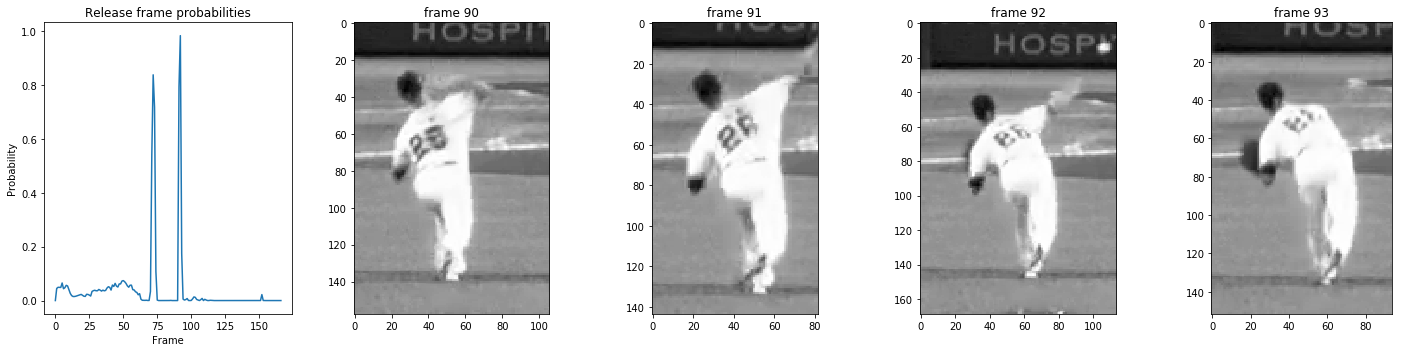

In [8]:
# HIGHER SHOULDER RELEASE FRAME

release_higher_shoulder = hs_release(pitcher)
print("Higher shoulders approach:", release_higher_shoulder)
plt.imshow(videos_p[release_higher_shoulder])
plt.gray()
plt.title("Higher shoulders approach")
plt.tight_layout()
plt.show()

# IMAGE RELEASE POSITION APPROACH (STANCE OF PITCHER RECOGNIZED WITH 2D CNN)

video_file = example+".mp4"

# For the image classification, a region of interest is required / helpful
for i in open(video_file+".dat").readlines():
        datContent=ast.literal_eval(i)        
bottom_p=datContent['Pitcher']['bottom']
left_p=datContent['Pitcher']['left']
right_p=datContent['Pitcher']['right']
top_p=datContent['Pitcher']['top']

box = [left_p, right_p, top_p, bottom_p] # bounding box 

# RU Release unrame from video function
release_from_video, release_probs = release_frame_2Dfrom_video(video_file, bbox = box, model = os.path.join(MODEL_PATH,"release_model"))

print("---- Release from pitcher's stance (frame by frame in 2D CNN): ", release_from_video, "--------")
# Plot
show_frames = range(release_from_video-2, release_from_video+2)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,len(show_frames)+1,1)
plt.plot(release_probs)
plt.title("Release frame probabilities")
plt.xlabel("Frame")
plt.ylabel("Probability")
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames)+1,ind+2)
    plt.imshow(videos_p[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# Batter's first movement: gradient and neural network method

INFO:tensorflow:Restoring parameters from saved_models/batter_first_step
time for nr labels 1.3698060512542725
--------------START RUN: network: 127 , gradient:  129 ------------------


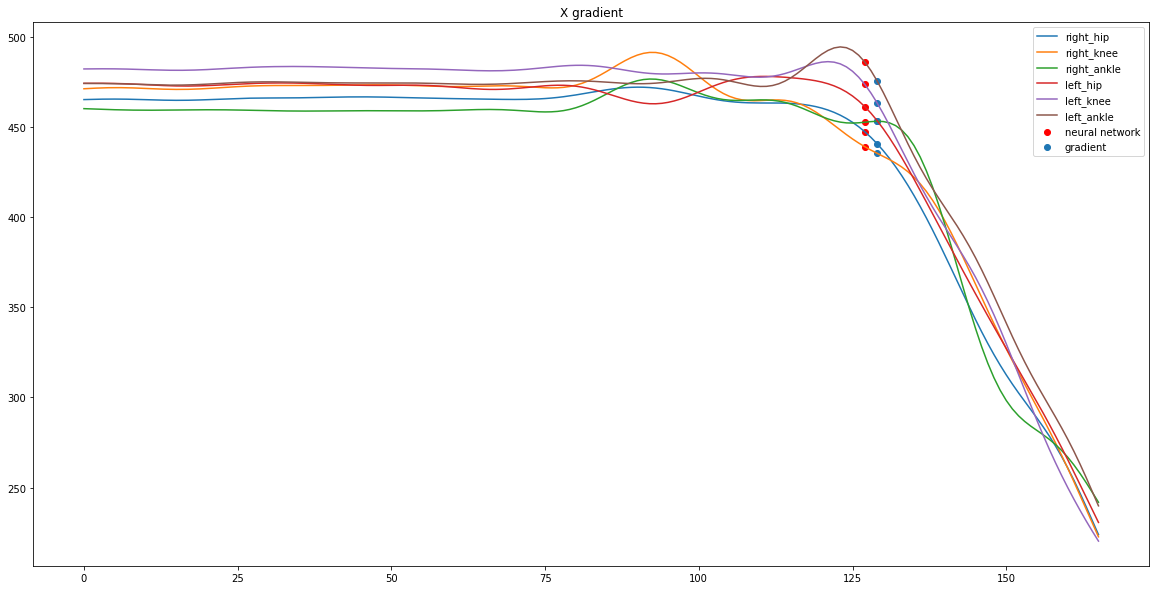

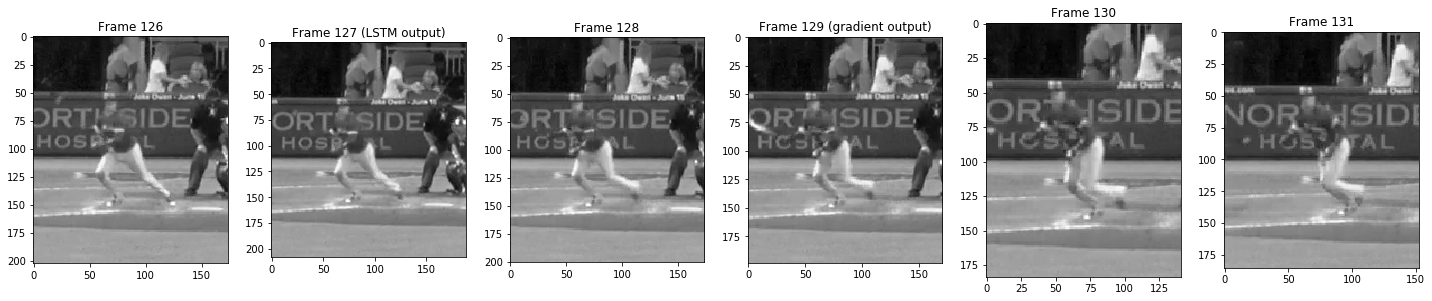

In [9]:
# gradient method
first_batter_gradient = first_move_gradient(batter)
# neural network
first_move_nn = first_move_batter_NN(np.array([batter]), [90], model = os.path.join(MODEL_PATH, "batter_first_step"))[0] # LATER HERE RELEASE FRAME
print("--------------START RUN: network:", first_move_nn, ", gradient: ", first_batter_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in joints_list[6:12]:
    plt.plot(batter[:,joints_list.index(j), 0], label = j)
plt.scatter([first_move_nn for _ in range(6)], batter[first_move_nn, 6:12, 0],  label = "neural network", color = "red")
plt.scatter([first_batter_gradient for _ in range(6)], batter[first_batter_gradient, 6:12, 0], label = "gradient")
plt.legend()
plt.title("X gradient")
plt.show()

show_frames = range(first_batter_gradient-3, first_batter_gradient+3)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    if i==first_batter_gradient:
        title = "Frame "+str(i)+" (gradient output)"
    elif i==first_move_nn:
        title = "Frame "+str(i)+" (LSTM output)"
    else:
        title="Frame "+str(i)
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_b[i])
    plt.gray()
    plt.title(title)
plt.tight_layout()
plt.show()

### Moment batter puts foot down

first step 127 , foot highest 91 , foot down 100


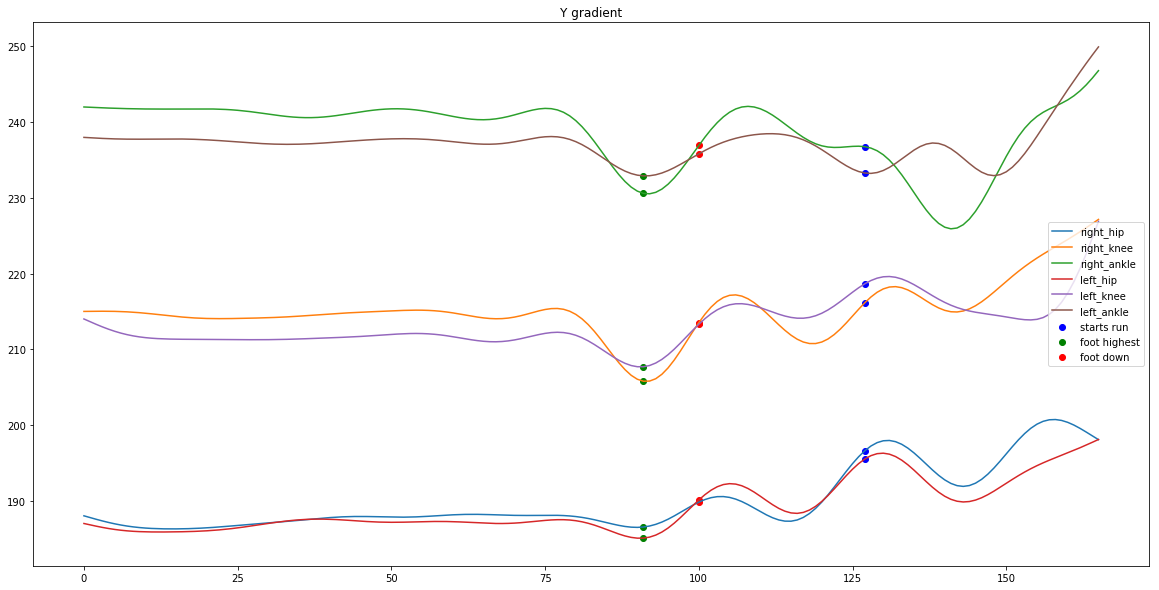

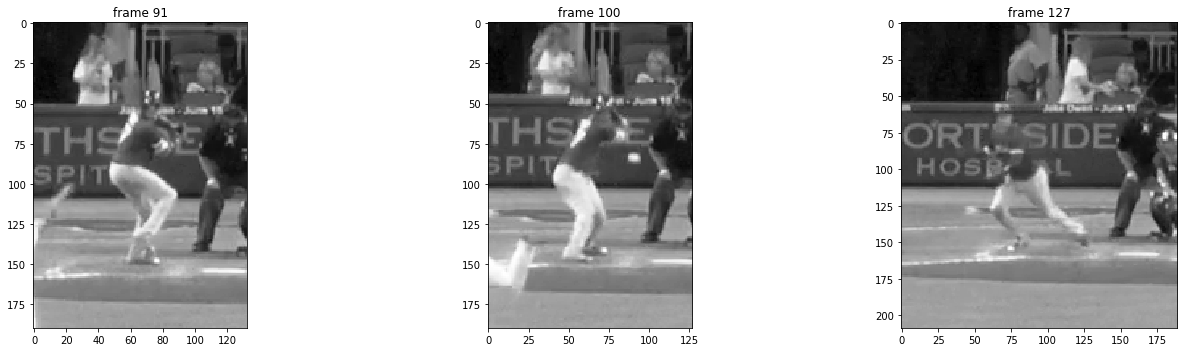

In [10]:
relevant_joints =[7,8,10,11]

foot_up, foot_down_gradient = foot_to_ground(batter, release= release_from_video, start_run = first_move_nn)
    
print("first step", first_move_nn, ", foot highest", foot_up, ", foot down", foot_down_gradient)

# print("--------------moment batter puts foot down", foot_down_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in joints_list[6:12]:
    plt.plot(batter[:,joints_list.index(j), 1], label = j)
plt.scatter([first_move_nn for _ in range(6)], batter[first_move_nn, 6:12, 1],  label = "starts run", color = "blue")
plt.scatter([foot_up for _ in range(6)], batter[foot_up, 6:12, 1],  label = "foot highest", color = "green")
plt.scatter([foot_down_gradient for _ in range(6)], batter[foot_down_gradient, 6:12, 1],  label = "foot down", color = "red")
plt.legend()
plt.title("Y gradient")
plt.show()

show_frames = [foot_up, foot_down_gradient, first_move_nn]
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_b[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# Fast moving object detection - for pitcher's first movement, ball detection and ball release frame

##  Release frame from ball detection, and ball trajectory

works better with side view video, because green background for ball detection

The release frame is not exact here, it is only the first time that the ball is detected. For a more precise release frame detection, the ball speed must be estimated. See the notebook called release_ball_detection for a precise release frame prediction


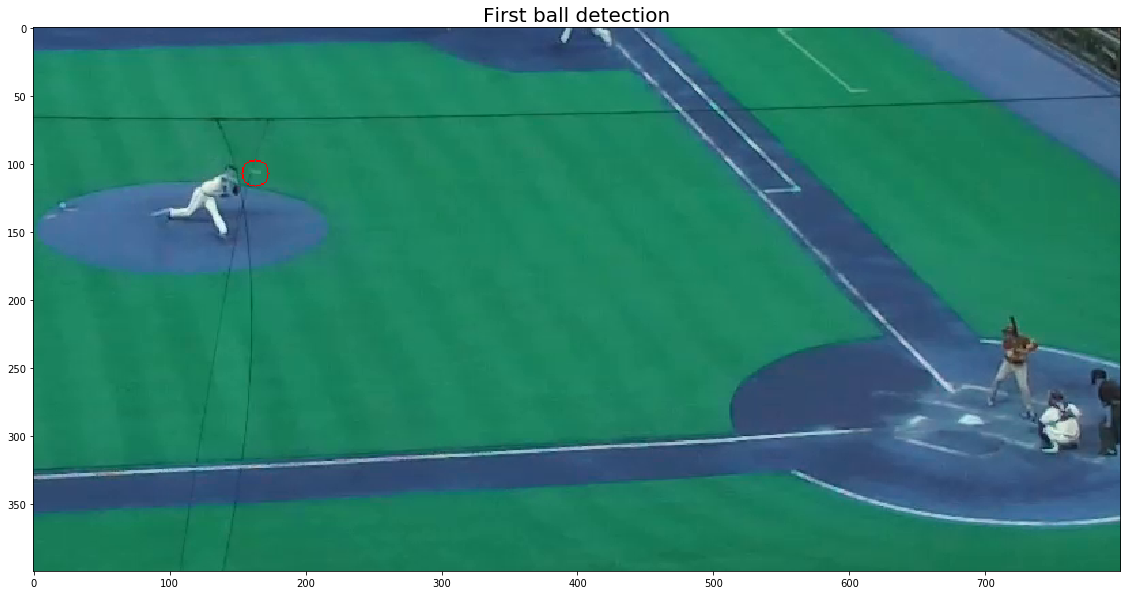

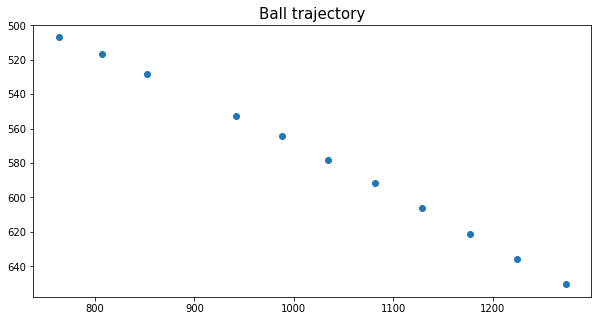

In [13]:
BASE = example+".m4v"
box = [400, 800, 600, 1400]
ball_trajectory, _, _ = detect_ball(BASE, joints_array = None, plotting=False, min_area=30, every_x_frame=1, roi=box)
ball_release = ball_trajectory[0,2]
print("The release frame is not exact here, it is only the first time that the ball is detected. For a more precise release frame detection, the ball speed must be estimated. See the notebook called release_ball_detection for a precise release frame prediction")

plt.figure(figsize = (20,10))
cap = cv2.VideoCapture(example+".m4v")
cap.set(cv2.CAP_PROP_POS_FRAMES, ball_release)
ret, frame = cap.read()
cv2.circle(frame, (int(ball_trajectory[0,0]), int(ball_trajectory[0,1])), 10, color=[255,0,0])
plt.imshow(frame[400:800, 600:1400])
plt.title("First ball detection", fontsize=20)
    
plot_trajectory(ball_trajectory)

# Pitcher's first movement:

### with FMO detection and with gradient
FMO detection for pitcher's first movement: better with center field video (and in this notebook only pose estimation for center field video is used)

Definition for pitcher's first movement: highest point of his leg when lifting his leg (then the video can be saved from 10 frames before

changes to fmo detection for release frame:
* joints array used (approach works by looking for FMO detections close to knee/ankle in some consecutive frames)
* bigger min_area used
* no roi required
* every_x_frame = 4 means that only every fourth frame is compared, such that slower movements are detected than for the ball

In [14]:
BASE = example+".mp4"
MIN_AREA = 40
_, first_move_frame, _ = detect_ball(BASE, joints_array = pitcher, plotting=False, min_area=MIN_AREA, every_x_frame=4, refine=False)

--------------PITCHER'S FIRST MOVE: FMO detection: Frame 69 , gradient: Frame 78 ------------------


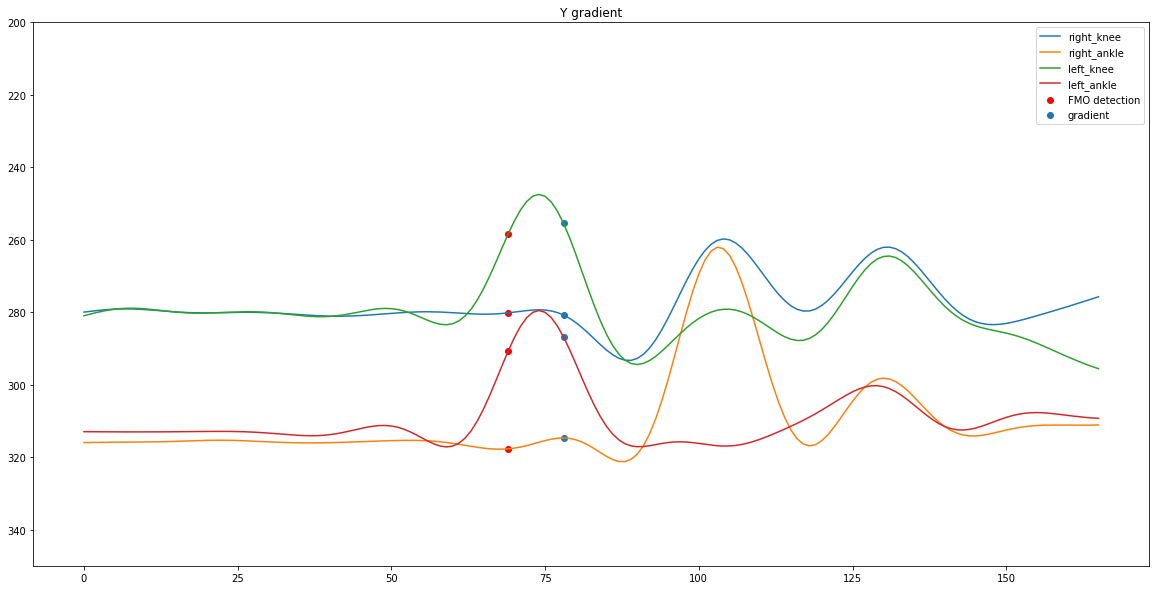

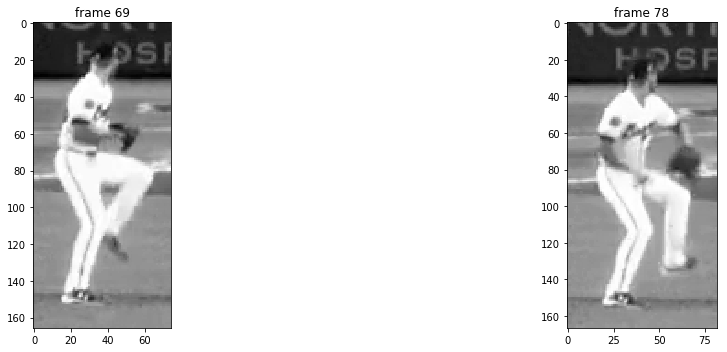

In [15]:
# changes to batter: 
# relevant_coordinate: Y coordinate (because lifting of leg) 
# relevant_joints_list: only knees and ankles

relevant_joints =[7,8,10,11]
first_pitcher_gradient = first_move_gradient(pitcher, relevant_joints_list=relevant_joints, relevant_coordinate=1, cutoff=2)


print("--------------PITCHER'S FIRST MOVE: FMO detection: Frame", first_move_frame, ", gradient: Frame", first_pitcher_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in np.array(joints_list)[[relevant_joints]]:
    plt.plot(pitcher[:,joints_list.index(j), 1], label = j)
plt.scatter([first_move_frame for _ in range(len(relevant_joints))], pitcher[first_move_frame, relevant_joints, 1],  label = "FMO detection", color = "red")
plt.scatter([first_pitcher_gradient for _ in range(len(relevant_joints))], pitcher[first_pitcher_gradient, relevant_joints, 1], label = "gradient")
plt.legend()
plt.title("Y gradient")
plt.ylim(350, 200)
plt.show()

show_frames = [first_move_frame, first_pitcher_gradient] # range(first_pitcher_gradient-5, first_pitcher_gradient+1)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_p[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# Timeline - all events

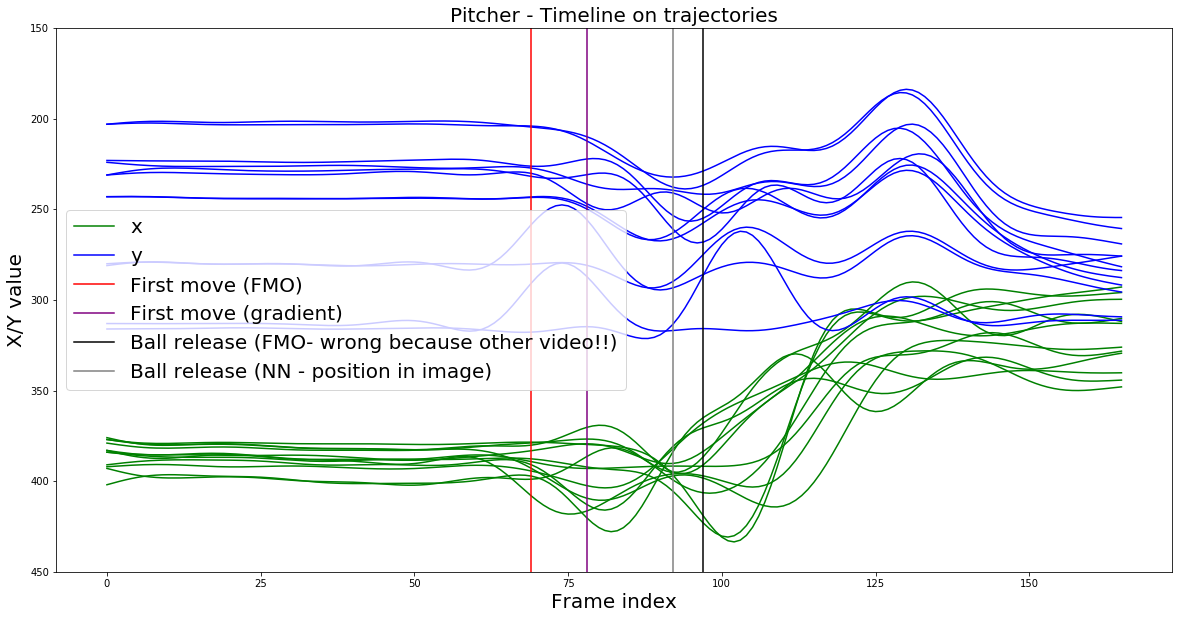

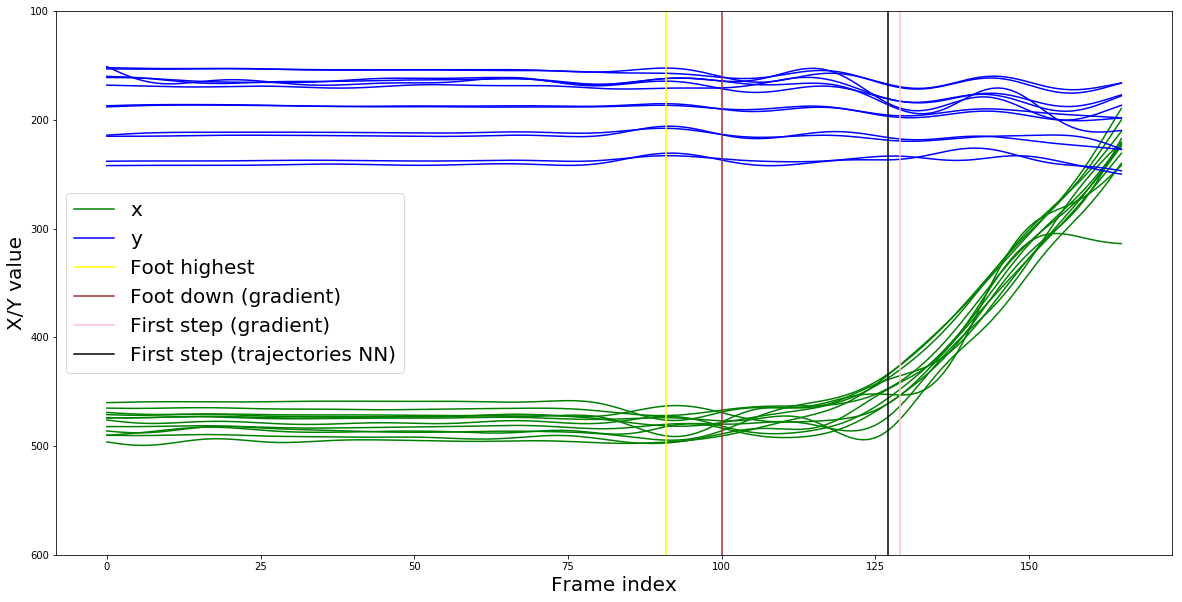

In [19]:
pitcher_events = {"First move (FMO)": first_move_frame, "First move (gradient)": first_pitcher_gradient,
                 "Ball release (FMO- wrong because other video!!)": ball_release,
                 "Ball release (NN - position in image)": release_from_video}
batter_events = {"Foot highest": foot_up, "Foot down (gradient)": foot_down_gradient, 
                "First step (gradient)": first_batter_gradient, "First step (trajectories NN)": first_move_nn}
col=["green", "blue","red", "purple","black", "gray", "orange", "yellow", "brown", "pink", "black"]
co = ["x","y"]
# PITCHER
limits = [450, 150]
plt.figure(figsize = (20,10))
for j in [0,1]:
    for k in range(12):
        if k==0:
            plt.plot(pitcher[:,k, j], label = co[j], color = col[j])
        else:
            plt.plot(pitcher[:,k, j], color = col[j])
for i, event in enumerate(list(pitcher_events.keys())):
    plt.plot([pitcher_events[event], pitcher_events[event]], limits, color=col[i+2], label=event)
plt.legend(fontsize=20)
plt.title("Pitcher - Timeline on trajectories", fontsize=20)
plt.ylim(limits[0], limits[1])
plt.ylabel("X/Y value", fontsize=20)
plt.xlabel("Frame index", fontsize=20)
plt.show()

# BATTER foot_up, foot_down_gradient first_move_gradient first_move_nn
limits = [600, 100]
plt.figure(figsize = (20,10))
for j in [0,1]:
    for k in range(12):
        if k==0:
            plt.plot(batter[:,k, j], label = co[j], color = col[j])
        else:
            plt.plot(batter[:,k, j], color = col[j])
for i, event in enumerate(list(batter_events.keys())):
    plt.plot([batter_events[event], batter_events[event]], limits, color=col[i+7], label=event)
plt.legend(fontsize=20)
# plt.title("Batter - Timeline on trajectories")
plt.ylim(limits[0], limits[1])
plt.ylabel("X/Y value", fontsize=20)
plt.xlabel("Frame index", fontsize=20)
plt.show()